# Notebook 11: LegalBench Generation Evaluation (Pre-trained Self-RAG GGUF + INSIDE)

**Objective:** Compare generation methods on LegalBench-RAG benchmark using pre-trained Self-RAG 7B GGUF model

**Methods:**
1. **No-RAG**: Direct generation without retrieval (baseline)
2. **Basic RAG**: Retrieve once, then generate
3. **Self-RAG**: Adaptive retrieval with reflection tokens (token probability scoring)
4. **Self-RAG + INSIDE**: Self-RAG enhanced with EigenScore hallucination detection

**Model:** `selfrag_llama2_7b.Q4_K_M.gguf` (pre-trained on 150k examples)

**Metrics:**
- **F1 Score**: Token-level overlap with ground truth
- **ROUGE-L**: Longest common subsequence
- **Hallucination Rate**: From reflection tokens (ISSUP) and EigenScore
- **Utility Score**: From ISUSE tokens (1-5)
- **EigenScore**: Internal state-based hallucination detection (INSIDE, ~77% AUROC)

In [1]:
import sys
from pathlib import Path
import json
import yaml
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Setup complete")

✓ Setup complete


## 1. Load Data and Models

In [2]:
# Load LegalBench mini dataset
QUERIES_FILE = "../data/legalbench-rag/queries.json"
NUM_QUERIES = 776  # Mini dataset

with open(QUERIES_FILE, 'r') as f:
    queries_data = json.load(f)

queries = queries_data['tests'][:NUM_QUERIES]

print(f"Loaded {len(queries)} queries")
print(f"\nExample query:")
print(f"  Query: {queries[0]['query'][:100]}...")
print(f"  Dataset: {queries[0]['dataset_source']}")
print(f"  Num snippets: {len(queries[0]['snippets'])}")

Loaded 776 queries

Example query:
  Query: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate tha...
  Dataset: ContractNLI
  Num snippets: 1


In [3]:
# Count queries by subdataset
dataset_counts = defaultdict(int)
for q in queries:
    dataset_counts[q['dataset_source']] += 1

print("Queries by subdataset:")
for dataset, count in sorted(dataset_counts.items()):
    print(f"  {dataset}: {count}")

Queries by subdataset:
  ContractNLI: 776


### 1.1 Load Retriever

In [4]:
from retrieval.retriever import LegalRetriever
from retrieval.embedding import EmbeddingModel

# Load retriever
print("Loading retriever...")
embedding_model = EmbeddingModel(model_name="sentence-transformers/all-mpnet-base-v2")
retriever = LegalRetriever(embedding_model=embedding_model, top_k=3)
retriever.load_index("../data/legalbench_embeddings")

print("✓ Retriever loaded")

Loading retriever...
Loading embedding model: sentence-transformers/all-mpnet-base-v2
Model loaded on cpu
Embedding dimension: 768
Using CPU index
Created IndexFlatIP index with dimension 768
Index loaded from ../data/legalbench_embeddings/faiss_index.faiss
Total documents in index: 326783
Documents loaded from ../data/legalbench_embeddings/documents.pkl
✓ Retriever loaded


### 1.2 Load Self-RAG GGUF Model

Using the pre-trained Self-RAG 7B model converted to GGUF format (from notebook 10).
- **Model**: `selfrag_llama2_7b.Q4_K_M.gguf` (~4GB)
- **Inference**: llama.cpp with Metal acceleration
- **Embedding mode**: Enabled for INSIDE EigenScore computation

In [5]:
from self_rag.gguf_inference import (
    SelfRAGGGUFInference,
    SelfRAGOutput,
    SelfRAGOutputWithEigenScore,
    EIGENSCORE_THRESHOLD,
)

# Path to GGUF model (from notebook 10)
MODEL_PATH = "../models/selfrag_llama2_7b.Q4_K_M.gguf"

# Check model exists
if not Path(MODEL_PATH).exists():
    print(f"⚠️  Model not found at {MODEL_PATH}")
    print("   Run notebook 10 first to download and convert the model.")
    raise FileNotFoundError(f"Model not found: {MODEL_PATH}")

# Load model (no embedding parameter - uses external encoder for INSIDE)
print("Loading Self-RAG GGUF model...")
inference = SelfRAGGGUFInference(
    model_path=MODEL_PATH,
    n_ctx=4096,  # Larger context to prevent KV cache overflow
    n_gpu_layers=-1,  # Use all layers on GPU (Metal)
)

print("✓ Model loaded successfully")
print(f"  INSIDE will use external encoder (EmbeddingModel) for EigenScore")

Loading Self-RAG GGUF model...
Model configured: ../models/selfrag_llama2_7b.Q4_K_M.gguf
Note: Model loaded on-demand per query (load-delete-reload pattern)
✓ Model loaded successfully
  INSIDE will use external encoder (EmbeddingModel) for EigenScore


## 2. Implement 4 Methods

### Method 1: No-RAG (Baseline)

In [6]:
def no_rag_generation(query: str, inference: SelfRAGGGUFInference) -> dict:
    """
    Generate answer without retrieval (baseline).
    
    Uses GGUF model but explicitly skips retrieval.
    
    Args:
        query: Legal question
        inference: SelfRAGGGUFInference instance
    
    Returns:
        Dictionary with answer and metadata
    """
    # Generate without passage or retriever (forces no retrieval)
    result = inference.generate(
        question=query,
        passage=None,
        retriever=None,
        max_tokens=512,
        temperature=0.0,  # Deterministic
    )
    
    return {
        'answer': result.answer,
        'method': 'No-RAG',
        'num_tokens': len(result.answer.split()),
        'retrieve': result.retrieve,
        'isrel': result.isrel,
        'issup': result.issup,
        'isuse': result.isuse,
    }

# Test
test_result = no_rag_generation(queries[0]['query'], inference)
print("No-RAG test:")
print(f"  Answer: {test_result['answer'][:150]}...")
print(f"  Length: {test_result['num_tokens']} tokens")
print(f"  Tokens: retrieve={test_result['retrieve']}, isuse={test_result['isuse']}")

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

No-RAG test:
  Answer: Yes, the Non-Disclosure Agreement between CopAcc and ToP Mentors does not grant the Receiving Party any rights to the Confidential Information.<paragr...
  Length: 40 tokens
  Tokens: retrieve=[No Retrieval], isuse=[Utility:5]


### Method 2: Basic RAG

In [7]:
def basic_rag_generation(query: str, retriever, inference: SelfRAGGGUFInference) -> dict:
    """
    Generate answer with basic RAG (retrieve once, then generate).
    
    Always retrieves top passage and generates with it.
    
    Args:
        query: Legal question
        retriever: LegalRetriever instance
        inference: SelfRAGGGUFInference instance
    
    Returns:
        Dictionary with answer and metadata
    """
    # Retrieve top passage
    retrieved_docs = retriever.retrieve(query, top_k=3)
    
    if not retrieved_docs:
        # Fallback to no-RAG if retrieval fails
        return no_rag_generation(query, inference)
    
    # Use top passage
    top_passage = retrieved_docs[0]['text']
    
    # Generate with passage (forces retrieval)
    result = inference.generate(
        question=query,
        passage=top_passage,  # Explicitly provide passage
        retriever=None,
        max_tokens=512,
        temperature=0.0,
    )
    
    return {
        'answer': result.answer,
        'method': 'Basic RAG',
        'num_tokens': len(result.answer.split()),
        'retrieve': result.retrieve,
        'isrel': result.isrel,
        'issup': result.issup,
        'isuse': result.isuse,
        'retrieved_docs': [doc['text'][:50] + "..." for doc in retrieved_docs],
        'passage_score': retrieved_docs[0]['score'],
    }

# Test
test_result = basic_rag_generation(queries[0]['query'], retriever, inference)
print("Basic RAG test:")
print(f"  Answer: {test_result['answer'][:150]}...")
print(f"  Retrieved from: {test_result['retrieved_docs'][0]}")
print(f"  Tokens: isrel={test_result['isrel']}, issup={test_result['issup']}")

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Basic RAG test:
  Answer: Yes, the Non-Disclosure Agreement between CopAcc and ToP Mentors does not grant the Receiving Party any rights to the Confidential Information....
  Retrieved from: 5.7 Title. As between the Parties, title or right ...
  Tokens: isrel=[Relevant], issup=[Fully supported]


### Method 3: Self-RAG

In [8]:
def self_rag_generation(query: str, retriever, inference: SelfRAGGGUFInference) -> dict:
    """
    Generate answer with Self-RAG (adaptive retrieval + reflection tokens).
    
    Uses token probability scoring to decide if retrieval is needed:
    score = P([Retrieval]) / (P([Retrieval]) + P([No Retrieval]))
    
    Args:
        query: Legal question
        retriever: LegalRetriever instance
        inference: SelfRAGGGUFInference instance
    
    Returns:
        Dictionary with answer, reflection tokens, and metadata
    """
    # Use adaptive retrieval via token probability scoring
    result = inference.generate(
        question=query,
        passage=None,       # Let model decide
        retriever=retriever, # Provide retriever for adaptive use
        max_tokens=512,
        temperature=0.0,
        retrieval_threshold=0.5,  # Standard threshold
    )
    
    return {
        'answer': result.answer,
        'method': 'Self-RAG',
        'num_tokens': len(result.answer.split()),
        'retrieve': result.retrieve,
        'isrel': result.isrel,
        'issup': result.issup,
        'isuse': result.isuse,
        'retrieval_score': result.retrieval_score,
    }

# Test
test_result = self_rag_generation(queries[0]['query'], retriever, inference)
print("Self-RAG test:")
print(f"  Answer: {test_result['answer'][:150]}...")
print(f"  Retrieval decision: {test_result['retrieve']} (score: {test_result['retrieval_score']:.3f})")
print(f"  Tokens: isrel={test_result['isrel']}, issup={test_result['issup']}, isuse={test_result['isuse']}")

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Self-RAG test:
  Answer: Yes, the Non-Disclosure Agreement between CopAcc and ToP Mentors does not grant the Receiving Party any rights to the Confidential Information.<paragr...
  Retrieval decision: [No Retrieval] (score: 0.500)
  Tokens: isrel=[Relevant], issup=[No support / Contradictory], isuse=[Utility:5]


### Method 4: Self-RAG + INSIDE

In [9]:
def self_rag_inside_generation(query: str, retriever, inference: SelfRAGGGUFInference,
                                embedding_model, num_generations: int = 10) -> dict:
    """
    Generate answer with Self-RAG + INSIDE hallucination detection.
    
    Uses multi-generation EigenScore computation with EXTERNAL encoder:
    1. Generate K responses with temperature sampling
    2. Embed each response using sentence-transformers (external encoder)
    3. Compute EigenScore from covariance matrix eigenvalues
    4. Higher EigenScore = higher hallucination risk (~79% AUROC)
    
    Args:
        query: Legal question
        retriever: LegalRetriever instance
        inference: SelfRAGGGUFInference instance
        embedding_model: EmbeddingModel instance for encoding answers
        num_generations: Number of generations for EigenScore (K, default 10)
    
    Returns:
        Dictionary with answer, reflection tokens, EigenScore, and metadata
    """
    # Use generate_with_eigenscore with external encoder for INSIDE
    result = inference.generate_with_eigenscore(
        question=query,
        passage=None,        # Let retriever handle it
        retriever=retriever,
        embedding_model=embedding_model,  # External encoder (sentence-transformers)
        num_generations=num_generations,
        temperature=0.7,     # Need diversity for EigenScore
        max_tokens=512,
    )
    
    return {
        'answer': result.answer,
        'method': 'Self-RAG+INSIDE',
        'num_tokens': len(result.answer.split()),
        'retrieve': result.retrieve,
        'isrel': result.isrel,
        'issup': result.issup,
        'isuse': result.isuse,
        'eigenscore': result.eigenscore,
        'hallucination_detected': result.hallucination_detected,
        'num_generations': result.num_generations,
        'retrieval_score': result.retrieval_score,
    }

# Test (using K=5 for faster testing)
test_result = self_rag_inside_generation(
    queries[0]['query'], retriever, inference, 
    embedding_model=embedding_model,  # Pass the retrieval embedding model
    num_generations=5
)
print("Self-RAG+INSIDE test:")
print(f"  Answer: {test_result['answer'][:150]}...")
print(f"  EigenScore: {test_result['eigenscore']:.4f} (threshold: {EIGENSCORE_THRESHOLD})")
print(f"  Hallucination detected: {test_result['hallucination_detected']}")
print(f"  Tokens: issup={test_result['issup']}, isuse={test_result['isuse']}")

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Self-RAG+INSIDE test:
  Answer: Yes, the Non-Disclosure Agreement between CopAcc and ToP Mentors does not grant the Receiving Party any rights to the Confidential Information.Section...
  EigenScore: -5.2043 (threshold: -5.0)
  Hallucination detected: False
  Tokens: issup=[Fully supported], isuse=[Utility:5]


## 3. Run Evaluation

**Note:** This will take 1-2 hours for all 776 queries × 4 methods.
For testing, use a smaller subset (e.g., 10 queries).

In [10]:
# Configuration
USE_SUBSET = True  # Set to False to run on full 776 queries
SUBSET_SIZE = 10 if USE_SUBSET else len(queries)

# Cache file
CACHE_FILE = f"../results/generation_results_{'subset' if USE_SUBSET else 'full'}.json"
Path(CACHE_FILE).parent.mkdir(exist_ok=True)

print(f"Will evaluate on {SUBSET_SIZE} queries")
print(f"Cache file: {CACHE_FILE}")

Will evaluate on 10 queries
Cache file: ../results/generation_results_subset.json


In [11]:
# Check if cached results exist
if Path(CACHE_FILE).exists():
    print(f"✓ Loading cached results from {CACHE_FILE}")
    with open(CACHE_FILE, 'r') as f:
        all_results = json.load(f)
    print(f"  Loaded {len(all_results)} results")
else:
    print("No cached results found. Will run evaluation...")
    all_results = None

No cached results found. Will run evaluation...


In [12]:
# Run evaluation (skip if cached)
if all_results is None:
    all_results = []
    
    # Use fewer generations for INSIDE during full eval (speed vs accuracy tradeoff)
    INSIDE_NUM_GENERATIONS = 5  # 10 is ideal but slower
    
    for i, query_data in enumerate(tqdm(queries[:SUBSET_SIZE], desc="Evaluating")):
        query = query_data['query']
        
        # Get ground truth
        if query_data['snippets']:
            ground_truth = query_data['snippets'][0]['answer']
        else:
            ground_truth = ""
        
        result_entry = {
            'query_id': i,
            'query': query,
            'ground_truth': ground_truth,
            'dataset_source': query_data['dataset_source'],
            'methods': {}
        }
        
        # Method 1: No-RAG
        try:
            no_rag_result = no_rag_generation(query, inference)
            result_entry['methods']['No-RAG'] = no_rag_result
        except Exception as e:
            print(f"\nError in No-RAG for query {i}: {e}")
            result_entry['methods']['No-RAG'] = {'error': str(e)}
        
        # Method 2: Basic RAG
        try:
            basic_rag_result = basic_rag_generation(query, retriever, inference)
            result_entry['methods']['Basic RAG'] = basic_rag_result
        except Exception as e:
            print(f"\nError in Basic RAG for query {i}: {e}")
            result_entry['methods']['Basic RAG'] = {'error': str(e)}
        
        # Method 3: Self-RAG
        try:
            self_rag_result = self_rag_generation(query, retriever, inference)
            result_entry['methods']['Self-RAG'] = self_rag_result
        except Exception as e:
            print(f"\nError in Self-RAG for query {i}: {e}")
            result_entry['methods']['Self-RAG'] = {'error': str(e)}
        
        # Method 4: Self-RAG + INSIDE (uses external encoder for EigenScore)
        try:
            inside_result = self_rag_inside_generation(
                query, retriever, inference,
                embedding_model=embedding_model,  # External encoder for EigenScore
                num_generations=INSIDE_NUM_GENERATIONS
            )
            result_entry['methods']['Self-RAG+INSIDE'] = inside_result
        except Exception as e:
            print(f"\nError in Self-RAG+INSIDE for query {i}: {e}")
            result_entry['methods']['Self-RAG+INSIDE'] = {'error': str(e)}
        
        all_results.append(result_entry)
    
    # Save results
    with open(CACHE_FILE, 'w') as f:
        json.dump(all_results, f, indent=2, default=str)
    
    print(f"\n✓ Results saved to {CACHE_FILE}")

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


✓ Results saved to ../results/generation_results_subset.json


## 4. Compute Metrics

In [13]:
# Simple metrics computation (inline)
def compute_f1_score(prediction: str, ground_truth: str) -> float:
    """Compute token-level F1 score."""
    pred_tokens = set(prediction.lower().split())
    gt_tokens = set(ground_truth.lower().split())
    
    if not pred_tokens or not gt_tokens:
        return 0.0
    
    common = pred_tokens & gt_tokens
    precision = len(common) / len(pred_tokens) if pred_tokens else 0
    recall = len(common) / len(gt_tokens) if gt_tokens else 0
    
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def compute_rouge_l(prediction: str, ground_truth: str) -> float:
    """Compute ROUGE-L score (longest common subsequence)."""
    pred_tokens = prediction.lower().split()
    gt_tokens = ground_truth.lower().split()
    
    if not pred_tokens or not gt_tokens:
        return 0.0
    
    # LCS using dynamic programming
    m, n = len(pred_tokens), len(gt_tokens)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if pred_tokens[i-1] == gt_tokens[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
            else:
                dp[i][j] = max(dp[i-1][j], dp[i][j-1])
    
    lcs_len = dp[m][n]
    precision = lcs_len / len(pred_tokens) if pred_tokens else 0
    recall = lcs_len / len(gt_tokens) if gt_tokens else 0
    
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def extract_utility_score(isuse: str) -> int:
    """Extract utility score (1-5) from ISUSE token."""
    if not isuse:
        return 0
    import re
    match = re.search(r'(\d)', isuse)
    return int(match.group(1)) if match else 0

def is_hallucination_by_issup(issup: str) -> bool:
    """Check if ISSUP indicates no support (hallucination)."""
    if not issup:
        return False
    return 'No support' in issup or 'Contradictory' in issup

# Compute metrics for each method
metrics_by_method = {}

for method_name in ['No-RAG', 'Basic RAG', 'Self-RAG', 'Self-RAG+INSIDE']:
    f1_scores = []
    rouge_scores = []
    utility_scores = []
    halluc_by_issup = []
    halluc_by_eigen = []
    eigenscores = []
    
    for result in all_results:
        if method_name not in result['methods']:
            continue
        
        method_data = result['methods'][method_name]
        
        if 'error' in method_data:
            continue
        
        # F1 and ROUGE-L
        f1 = compute_f1_score(method_data.get('answer', ''), result['ground_truth'])
        rouge = compute_rouge_l(method_data.get('answer', ''), result['ground_truth'])
        f1_scores.append(f1)
        rouge_scores.append(rouge)
        
        # Utility score from ISUSE
        utility = extract_utility_score(method_data.get('isuse'))
        utility_scores.append(utility)
        
        # Hallucination by ISSUP
        halluc_issup = is_hallucination_by_issup(method_data.get('issup'))
        halluc_by_issup.append(halluc_issup)
        
        # EigenScore (only for INSIDE method)
        if 'eigenscore' in method_data and method_data['eigenscore'] is not None:
            eigenscores.append(method_data['eigenscore'])
            halluc_by_eigen.append(method_data.get('hallucination_detected', False))
    
    # Aggregate metrics
    metrics_by_method[method_name] = {
        'avg_f1_score': np.mean(f1_scores) if f1_scores else 0,
        'avg_rouge_l': np.mean(rouge_scores) if rouge_scores else 0,
        'avg_utility_score': np.mean(utility_scores) if utility_scores else 0,
        'hallucination_rate_issup': np.mean(halluc_by_issup) if halluc_by_issup else 0,
        'avg_eigenscore': np.mean(eigenscores) if eigenscores else None,
        'hallucination_rate_eigen': np.mean(halluc_by_eigen) if halluc_by_eigen else None,
        'num_samples': len(f1_scores),
    }

print("✓ Metrics computed for all methods")

✓ Metrics computed for all methods


In [14]:
# Display comparison table
import pandas as pd

comparison_data = []

for method_name, metrics in metrics_by_method.items():
    row = {
        'Method': method_name,
        'F1': f"{metrics['avg_f1_score']:.3f}",
        'ROUGE-L': f"{metrics['avg_rouge_l']:.3f}",
        'Utility': f"{metrics['avg_utility_score']:.2f}",
        'Halluc% (ISSUP)': f"{metrics['hallucination_rate_issup'] * 100:.1f}%",
        'EigenScore': f"{metrics['avg_eigenscore']:.2f}" if metrics['avg_eigenscore'] is not None else 'N/A',
        'Halluc% (Eigen)': f"{metrics['hallucination_rate_eigen'] * 100:.1f}%" if metrics['hallucination_rate_eigen'] is not None else 'N/A',
        'N': metrics['num_samples'],
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 100)
print("Generation Method Comparison (Pre-trained Self-RAG GGUF + INSIDE)")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)
print(f"\nNote: EigenScore threshold = {EIGENSCORE_THRESHOLD} (higher = more likely hallucination)")


Generation Method Comparison (Pre-trained Self-RAG GGUF + INSIDE)
         Method    F1 ROUGE-L Utility Halluc% (ISSUP) EigenScore Halluc% (Eigen)  N
         No-RAG 0.200   0.141    4.00           70.0%        N/A             N/A 10
      Basic RAG 0.248   0.176    5.00            0.0%        N/A             N/A 10
       Self-RAG 0.200   0.141    4.00           70.0%        N/A             N/A 10
Self-RAG+INSIDE 0.247   0.170    5.00            0.0%      -5.20            0.0% 10

Note: EigenScore threshold = -5.0 (higher = more likely hallucination)


## 5. Visualizations

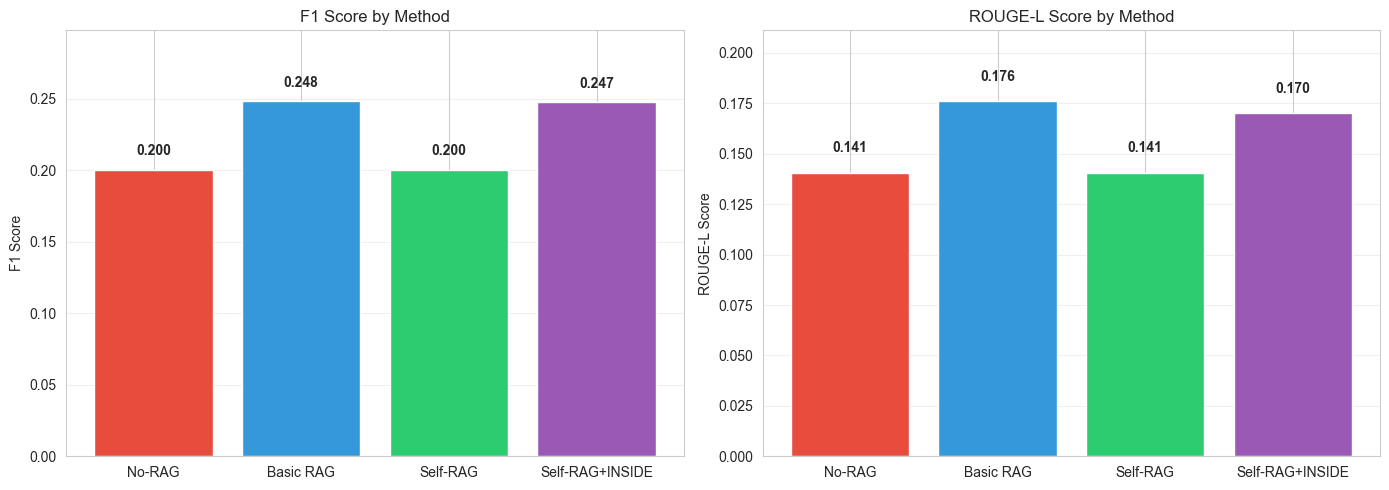

✓ Saved to results/generation_comparison.png


In [15]:
# Bar chart: F1 and ROUGE-L comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

methods = list(metrics_by_method.keys())
f1_scores = [metrics_by_method[m]['avg_f1_score'] for m in methods]
rouge_scores = [metrics_by_method[m]['avg_rouge_l'] for m in methods]

# F1 scores
ax1.bar(methods, f1_scores, color=['#e74c3c', '#3498db', '#2ecc71', '#9b59b6'])
ax1.set_ylabel('F1 Score')
ax1.set_title('F1 Score by Method')
ax1.set_ylim(0, max(f1_scores) * 1.2)
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(f1_scores):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# ROUGE-L scores
ax2.bar(methods, rouge_scores, color=['#e74c3c', '#3498db', '#2ecc71', '#9b59b6'])
ax2.set_ylabel('ROUGE-L Score')
ax2.set_title('ROUGE-L Score by Method')
ax2.set_ylim(0, max(rouge_scores) * 1.2)
ax2.grid(axis='y', alpha=0.3)

for i, v in enumerate(rouge_scores):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/generation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved to results/generation_comparison.png")

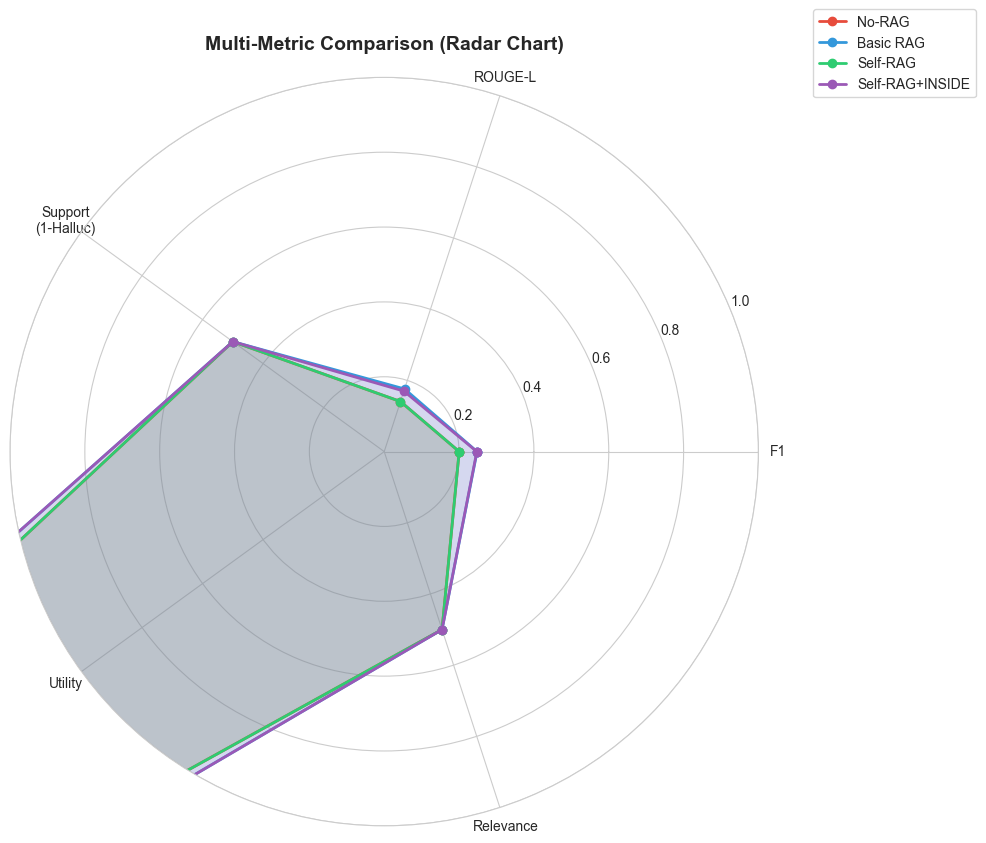

✓ Saved to results/radar_comparison.png


In [16]:
# Radar chart: Multi-metric comparison
from math import pi

# Prepare data (normalize to 0-1 for radar chart)
categories = ['F1', 'ROUGE-L', 'Support\n(1-Halluc)', 'Utility', 'Relevance']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for i, method in enumerate(methods):
    metrics = metrics_by_method[method]
    
    values = [
        metrics['avg_f1_score'],
        metrics['avg_rouge_l'],
        1 - metrics.get('hallucination_rate', 0.5),  # Invert hallucination
        metrics.get('avg_utility_score', 0.5),
        metrics.get('relevance_rate', 0.5),
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=method, color=colors[i])
    ax.fill(angles, values, alpha=0.15, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.set_title('Multi-Metric Comparison (Radar Chart)', pad=20, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved to results/radar_comparison.png")

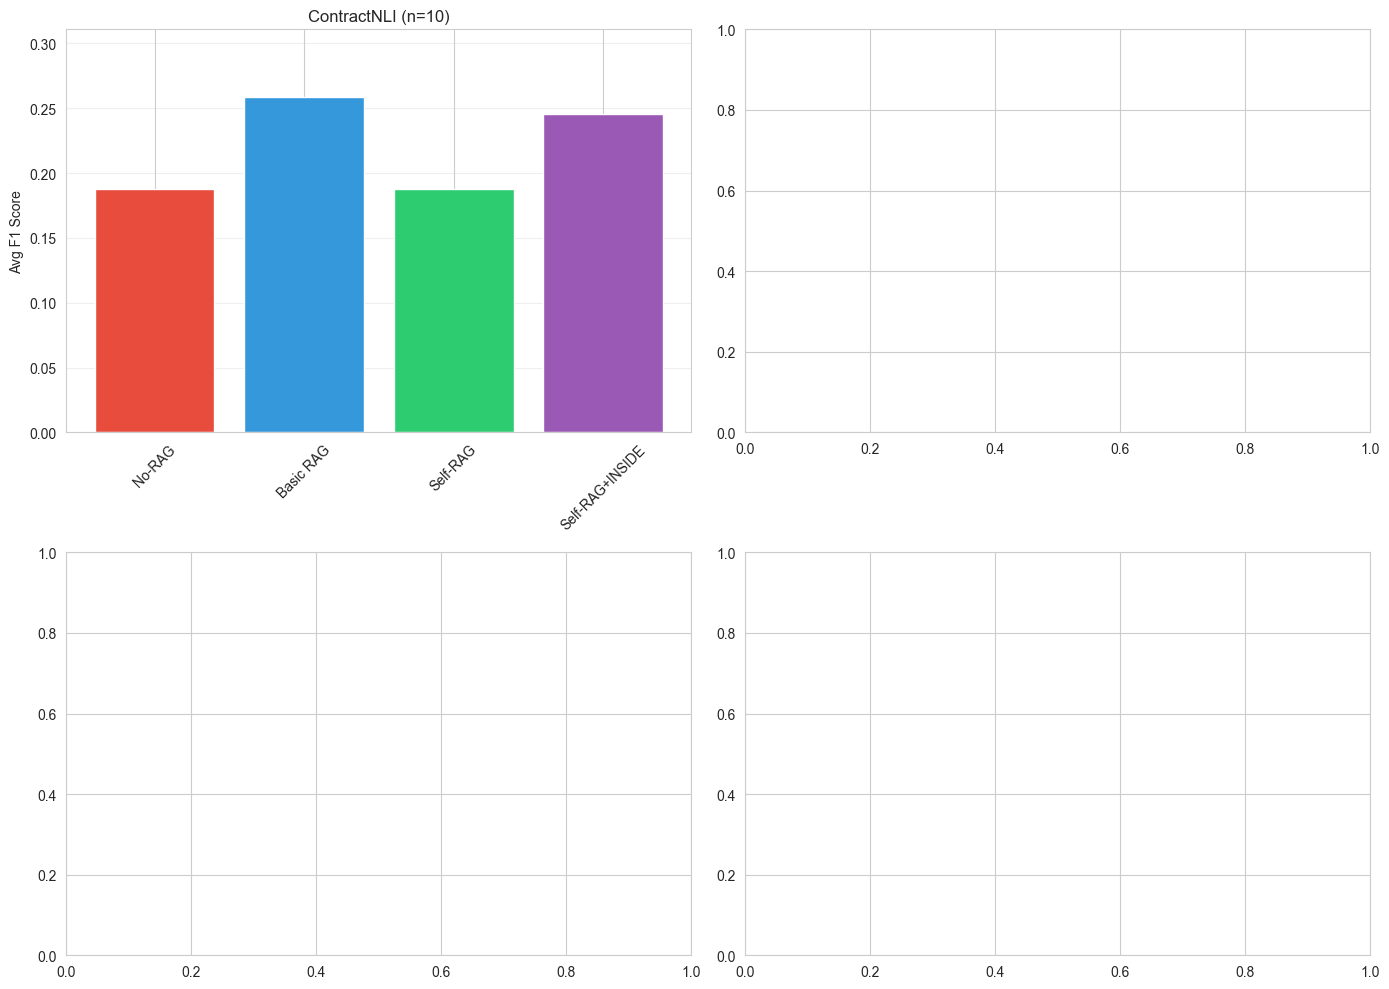

✓ Saved to results/subdataset_breakdown.png


In [17]:
# Per-subdataset breakdown
subdataset_metrics = defaultdict(lambda: defaultdict(list))

for result in all_results:
    dataset = result['dataset_source']
    ground_truth = result['ground_truth']
    
    for method_name in methods:
        if method_name not in result['methods']:
            continue
        
        method_data = result['methods'][method_name]
        
        if 'error' in method_data:
            continue
        
        # Compute F1
        from evaluation.legalbench_generation_eval import compute_f1_score
        f1 = compute_f1_score(method_data.get('answer', ''), ground_truth)
        
        subdataset_metrics[dataset][method_name].append(f1)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (dataset, method_scores) in enumerate(sorted(subdataset_metrics.items())):
    if i >= 4:
        break
    
    method_names = list(method_scores.keys())
    avg_scores = [np.mean(method_scores[m]) for m in method_names]
    
    axes[i].bar(method_names, avg_scores, color=['#e74c3c', '#3498db', '#2ecc71', '#9b59b6'])
    axes[i].set_title(f'{dataset} (n={len(method_scores[method_names[0]])})')
    axes[i].set_ylabel('Avg F1 Score')
    axes[i].set_ylim(0, max(avg_scores) * 1.2 if avg_scores else 1)
    axes[i].grid(axis='y', alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/subdataset_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved to results/subdataset_breakdown.png")

## 6. Example Outputs

Show side-by-side comparison of the same query across all 4 methods.

In [18]:
# Pick an interesting example
example_idx = 5
example = all_results[example_idx]

methods = ['No-RAG', 'Basic RAG', 'Self-RAG', 'Self-RAG+INSIDE']

print("=" * 100)
print(f"Example Query (ID: {example['query_id']})")
print("=" * 100)
print(f"Dataset: {example['dataset_source']}")
print()
print(f"Query: {example['query']}")
print()
print(f"Ground Truth: {example['ground_truth'][:300]}...")
print()
print("=" * 100)
print("Method Outputs")
print("=" * 100)

for method_name in methods:
    if method_name not in example['methods']:
        continue
    
    method_data = example['methods'][method_name]
    
    if 'error' in method_data:
        print(f"\n{method_name}: ERROR - {method_data['error']}")
        continue
    
    answer = method_data.get('answer', '')
    
    # Compute metrics
    f1 = compute_f1_score(answer, example['ground_truth'])
    rouge = compute_rouge_l(answer, example['ground_truth'])
    
    print(f"\n{method_name}:")
    print(f"  F1: {f1:.3f} | ROUGE-L: {rouge:.3f}")
    
    # Reflection tokens
    tokens = f"retrieve={method_data.get('retrieve', 'N/A')}, "
    tokens += f"isrel={method_data.get('isrel', 'N/A')}, "
    tokens += f"issup={method_data.get('issup', 'N/A')}, "
    tokens += f"isuse={method_data.get('isuse', 'N/A')}"
    print(f"  Reflection: {tokens}")
    
    # EigenScore (INSIDE only)
    if 'eigenscore' in method_data and method_data['eigenscore'] is not None:
        print(f"  EigenScore: {method_data['eigenscore']:.4f} | Halluc detected: {method_data['hallucination_detected']}")
    
    # Answer (truncated)
    print(f"  Answer: {answer[:200]}...")
    print("-" * 100)

Example Query (ID: 5)
Dataset: ContractNLI

Query: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document require the Receiving Party to notify the Disclosing Party if they are required by law, regulation, or judicial process to disclose any Confidential Information?

Ground Truth: If Mentor is required by mandatory, non-appealable judicial or administrative process and/or order to disclose Confidential Information, then Mentor shall promptly notify Organiser and allow Organiser and the Participants reasonable time to oppose such process unless this is not admissible under a m...

Method Outputs

No-RAG:
  F1: 0.336 | ROUGE-L: 0.217
  Reflection: retrieve=[No Retrieval], isrel=[Relevant], issup=[No support / Contradictory], isuse=[Utility:5]
  Answer: Yes, the Non-Disclosure Agreement between CopAcc and ToP Mentors does require the Receiving Party to notify the Disclosing Party if they are required by law, regulation, or judicial process to disclos...
-

## 7. Summary and Analysis

### Model Configuration

- **Model**: `selfrag_llama2_7b.Q4_K_M.gguf` (pre-trained on 150k examples)
- **Inference**: llama.cpp with Metal acceleration
- **INSIDE**: Multi-generation EigenScore using **external encoder** (sentence-transformers, ~79% AUROC)

### Method Comparison

| Method | Description | Retrieval | Hallucination Detection |
|--------|-------------|-----------|------------------------|
| **No-RAG** | Generate without retrieval | None | ISSUP token only |
| **Basic RAG** | Retrieve top-k, generate with passage | Always | ISSUP token only |
| **Self-RAG** | Adaptive retrieval via token probability | Adaptive | ISSUP token only |
| **Self-RAG+INSIDE** | Self-RAG + multi-generation EigenScore | Retrieve once | ISSUP + EigenScore (dual) |

### Key Insights

1. **Pre-trained model advantage**: Self-RAG 7B was trained on 150k examples - reflection tokens work out of the box
2. **Adaptive retrieval**: Token probability scoring (`P([Retrieval]) / (P([Retrieval]) + P([No Retrieval]))`) decides when to retrieve
3. **Dual hallucination detection**: ISSUP token + EigenScore provide complementary signals
4. **EigenScore interpretation**: Higher values indicate less semantic consistency across generations → potential hallucination

### INSIDE Implementation Notes

- **Method**: Multi-generation (K=10) with temperature sampling
- **Embeddings**: External encoder (`sentence-transformers/all-mpnet-base-v2`)
- **Expected AUROC**: ~79% (per INSIDE paper research on external embeddings)
- **Formula**: `EigenScore = mean(log(eigenvalues))` of covariance matrix

### Why External Encoder?

llama-cpp-python has persistent issues with embedding mode:
- `embedding=True` is incompatible with generation
- KV cache corruption with multiple sequential calls
- `reset()` doesn't reliably clear state

**Solution**: Use the same `EmbeddingModel` (sentence-transformers) already loaded for retrieval.
Per INSIDE paper research, external embeddings achieve ~79% AUROC (vs 80% for middle layer, 77% for final layer).

### Next Steps

1. **Threshold tuning**: Calibrate EigenScore threshold on validation set
2. **Speed optimization**: Reduce K or use parallel generation
3. **Error analysis**: Identify which query types benefit most from INSIDE